## Train deep calibration model for rough Bergomi models

In [33]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
from data_generation import blackscholes_implied_volatility, rbergomi_pricer
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [76]:
mpl.rc("figure", dpi=300)
mpl.rc("font", family="Serif", serif=["Times", "Palatino", "serif"], size=18)
mpl.rc("axes", labelsize=10)
mpl.rc("axes", titlesize=12)
mpl.rc("xtick", labelsize=8)
mpl.rc("ytick", labelsize=8)

# Adjust the linewidths for lines and borders
mpl.rc("lines", linewidth=1)
mpl.rc("patch", linewidth=1)

# Customize the grid appearance
mpl.rc("grid", linewidth=0.5)
mpl.rc("grid", linestyle="--")
mpl.rc("grid", alpha=0.7)

# Set the legend font size and frame properties
mpl.rc("legend", fontsize=8)
mpl.rc("legend", frameon=True)
mpl.rc("legend", framealpha=0.7)
mpl.rc("legend", facecolor="white")

In [35]:
# neural network
in_size = 6
out_size = 1
width_size = 64
depth = 20

# training
lr = 1e-4
n_epochs = 300
batch_size = 2048
seed = 123

### Prepare data

In [36]:
data_df = pd.read_csv("../data/rbergomi_data_500000.csv")

In [37]:
data_df = data_df.dropna()

In [38]:
X = data_df[["hurst", "rho", "eta", "xi", "moneyness", "maturity"]].to_numpy()
y = data_df["implied_vol"].to_numpy()

In [39]:
class NumpyDataset(Dataset):
    def __init__(self, X, y) -> None:
        super().__init__()
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [40]:
len_X = X.shape[0]
len_train = int(0.8 * len_X)
len_valid = int(0.1 * len_X)

X_train, y_train = X[:len_train], y[:len_train]
X_valid, y_valid = (
    X[len_train : len_train + len_valid],
    y[len_train : len_train + len_valid],
)
X_test, y_test = X[len_train + len_valid :], y[len_train + len_valid :]


# mean, std on train
X_mean, X_std = jnp.mean(X_train, axis=0, keepdims=True), jnp.std(
    X_train, axis=0, keepdims=True
)

train_dataset = NumpyDataset(X_train, y_train)
valid_dataset = NumpyDataset(X_valid, y_valid)
test_dataset = NumpyDataset(X_test, y_test)

In [41]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate
)
valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate
)

### Build neural network

In [42]:
key = jrandom.PRNGKey(seed)
model_key = key

model = eqx.nn.MLP(
    in_size=in_size,
    width_size=width_size,
    depth=depth,
    out_size=out_size,
    key=model_key,
)

optimizer = optax.adamw(learning_rate=lr, weight_decay=1e-5)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

In [43]:
def loss_fn(model, input, target):
    predict = jax.vmap(model)(input)
    return jnp.mean(optax.l2_loss(predict, target))


@eqx.filter_jit
def make_step(model, X_batch, y_batch, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, X_batch, y_batch)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)

    return loss, model, opt_state

In [44]:
epoch_progress = tqdm(range(n_epochs), desc="Epoch")
best_valid_loss = np.inf
for i in epoch_progress:
    total_loss = 0.0
    for batch in train_loader:
        X_batch, y_batch = batch

        # standardize
        X_batch = (X_batch - X_mean) / X_std

        loss, model, opt_state = make_step(model, X_batch, y_batch[:, None], opt_state)
        total_loss += loss.item()

    epoch_progress.set_description(f"Loss: {total_loss:.5f}")

    if i % 10 == 0:
        valid_loss = 0.0
        for batch in valid_loader:
            X_batch, y_batch = batch
            X_batch = (X_batch - X_mean) / X_std
            loss = eqx.filter_jit(loss_fn)(model, X_batch, y_batch[:, None])
            valid_loss += loss.item()
        epoch_progress.set_postfix_str(f"Valid loss: {valid_loss:.5f}")
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            eqx.tree_serialise_leaves("../checkpoint/calibrated.eqx", model)

Loss: 0.00782: 100%|██████████| 300/300 [06:46<00:00,  1.35s/it, Valid loss: 0.00187]


In [65]:
model = eqx.tree_deserialise_leaves("../checkpoint/calibrated.eqx", model)

In [66]:
pred_test = []
true_test = []

for batch in test_loader:
    X_batch, y_batch = batch
    X_batch = (X_batch - X_mean) / X_std
    pred = jax.vmap(model)(X_batch)
    pred_test.append(pred)
    true_test.append(y_batch)

pred_test = jnp.concatenate(pred_test)
true_test = jnp.concatenate(true_test)

In [67]:
pred_test = np.array(pred_test)
true_test = np.array(true_test)

In [68]:
relative_error = 100 * np.abs(np.squeeze(pred_test) - true_test) / true_test

In [69]:
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90 * len(relative_error))]
q_95 = sorted_re[int(0.95 * len(relative_error))]
q_99 = sorted_re[int(0.99 * len(relative_error))]

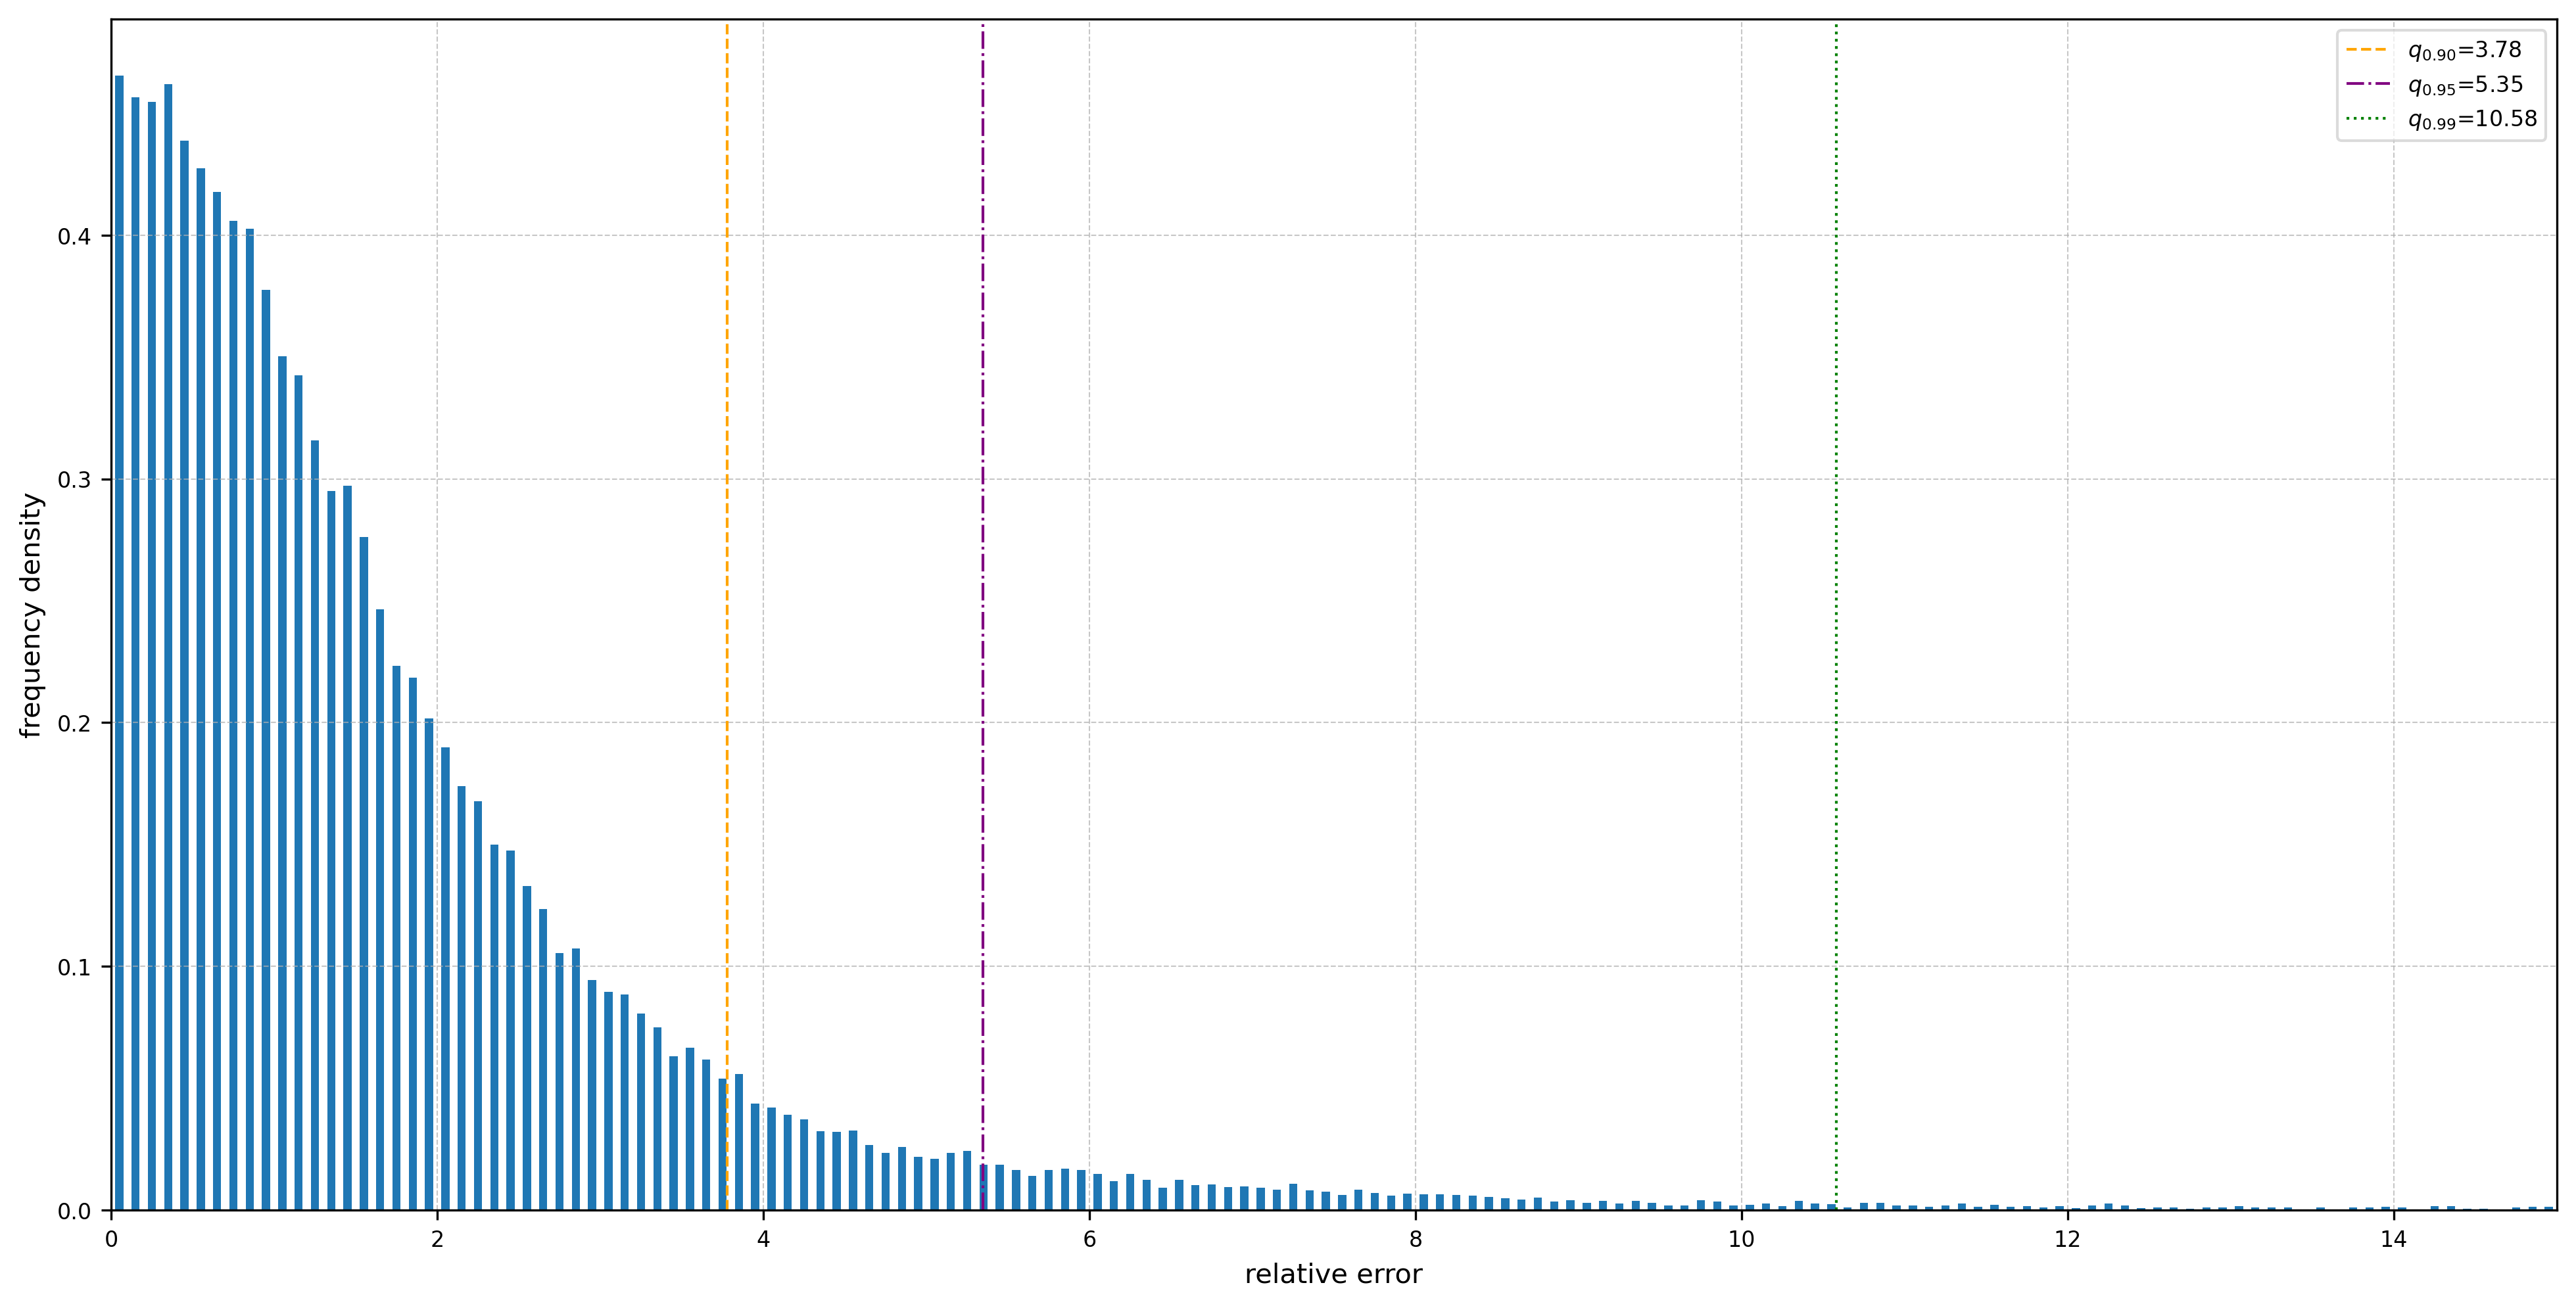

In [70]:
plt.figure(figsize=(16, 8))
plt.hist(relative_error, bins=np.linspace(0, 15, 151), density=True, rwidth=0.5)
plt.xlim((0, 15))
plt.grid(True)
plt.axvline(
    x=q_90, ls="--", color="orange", label=r"$q_{0.90}$" + "={:.2f}".format(q_90)
)
plt.axvline(
    x=q_95, ls="-.", color="purple", label=r"$q_{0.95}$" + "={:.2f}".format(q_95)
)
plt.axvline(x=q_99, ls=":", color="green", label=r"$q_{0.99}$" + "={:.2f}".format(q_99))
plt.legend(loc=1)
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()

In [71]:
log_moneyness = np.linspace(-0.1, 0.1, 20)
maturity = np.linspace(0.01, 0.18, 20)
log_moneyness, maturity = np.meshgrid(log_moneyness, maturity)

# columns ['moneyness', 'maturity', 'hurst', 'rho', 'eta',  'xi']
plot_df = pd.DataFrame(columns=data_df.columns)
plot_df["moneyness"] = np.exp(log_moneyness.flatten())
plot_df["maturity"] = maturity.flatten()
plot_df["hurst"] = 0.07
plot_df["rho"] = -0.9
plot_df["eta"] = 1.9
plot_df["xi"] = 0.01

In [72]:
X_plot = plot_df[["hurst", "rho", "eta", "xi", "moneyness", "maturity"]].to_numpy()
X_plot = jnp.array(X_plot)
X_plot = (X_plot - X_mean) / X_std
iv_nn = jax.vmap(model)(X_plot)

In [90]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D  # noqa


def plot_iv_surface(data, x="moneyness", y="maturity", z="iv"):
    """Plots the IV surface"""
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca(projection="3d")
    ax.azim = 120
    ax.elev = 13

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))

    surf = ax.plot_trisurf(
        np.log(data[x].to_numpy()),
        data[y],
        data[z],
        antialiased=True,
        cmap=plt.cm.Spectral,
    )
    fig.colorbar(surf, shrink=0.7, aspect=10)

    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Maturity")
    ax.set_zlabel("Implied Volatility")

    plt.tight_layout()

    plt.show()
    return fig

In [77]:
plot_df["iv"] = np.array(iv_nn)

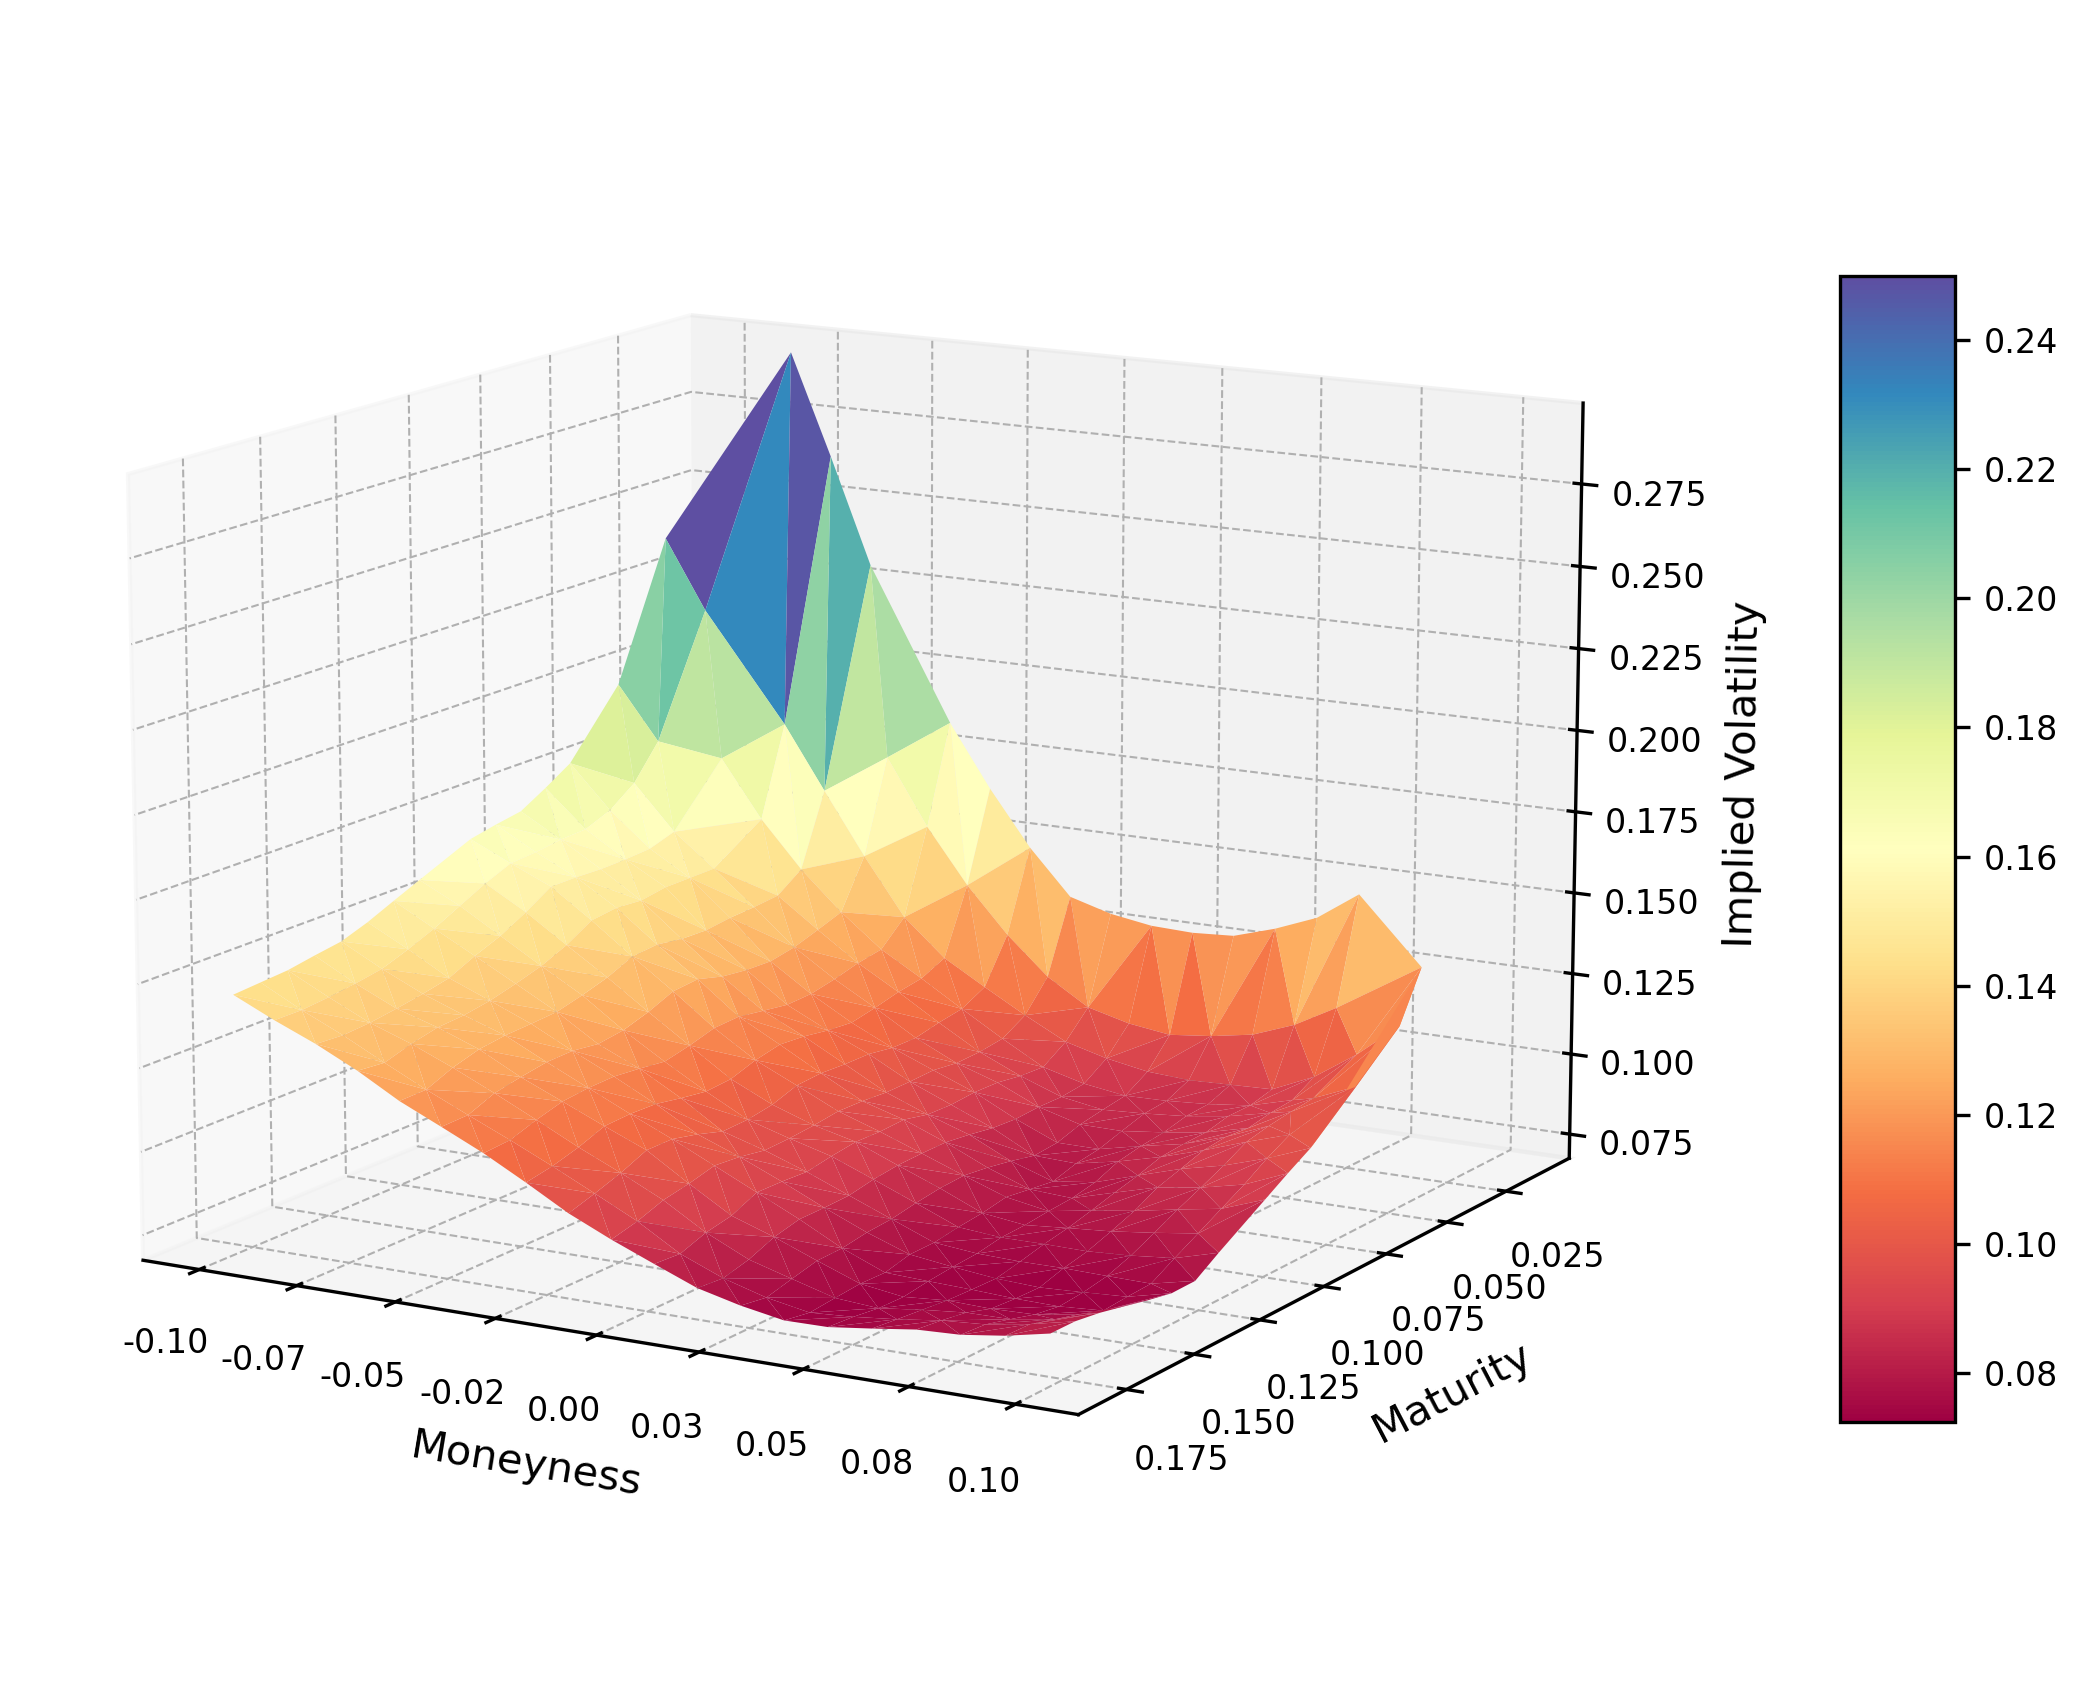

In [96]:
fig = plot_iv_surface(plot_df, z="iv")
fig.savefig("../output/implied_vol_nn.pdf", bbox_inches="tight")

In [82]:
price = rbergomi_pricer(
    hurst=jnp.array(plot_df["hurst"].to_numpy()),
    rho=jnp.array(plot_df["rho"].to_numpy()),
    xi=jnp.array(plot_df["xi"].to_numpy()),
    eta=jnp.array(plot_df["eta"].to_numpy()),
    S0=jnp.ones((len(plot_df))),
    K=jnp.array(plot_df["moneyness"].to_numpy()),
    maturity=jnp.array(plot_df["maturity"].to_numpy()),
    key=jrandom.PRNGKey(0),
)

In [83]:
implied_vol = blackscholes_implied_volatility(
    log_moneyness=jnp.log(1.0 / jnp.array(plot_df["moneyness"].to_numpy())),
    time_to_maturity=jnp.array(plot_df["maturity"].to_numpy()),
    strike=jnp.array(plot_df["moneyness"].to_numpy()),
    price=price,
)

In [84]:
implied_vol = jnp.where(
    price <= 0,
    jnp.nan,
    implied_vol,
)

In [85]:
plot_df["iv_true"] = np.array(implied_vol)

In [86]:
plot_df = plot_df.loc[:, ~plot_df.columns.str.contains("^Unnamed")]
plot_df = plot_df[plot_df["iv_true"] > 1e-2]

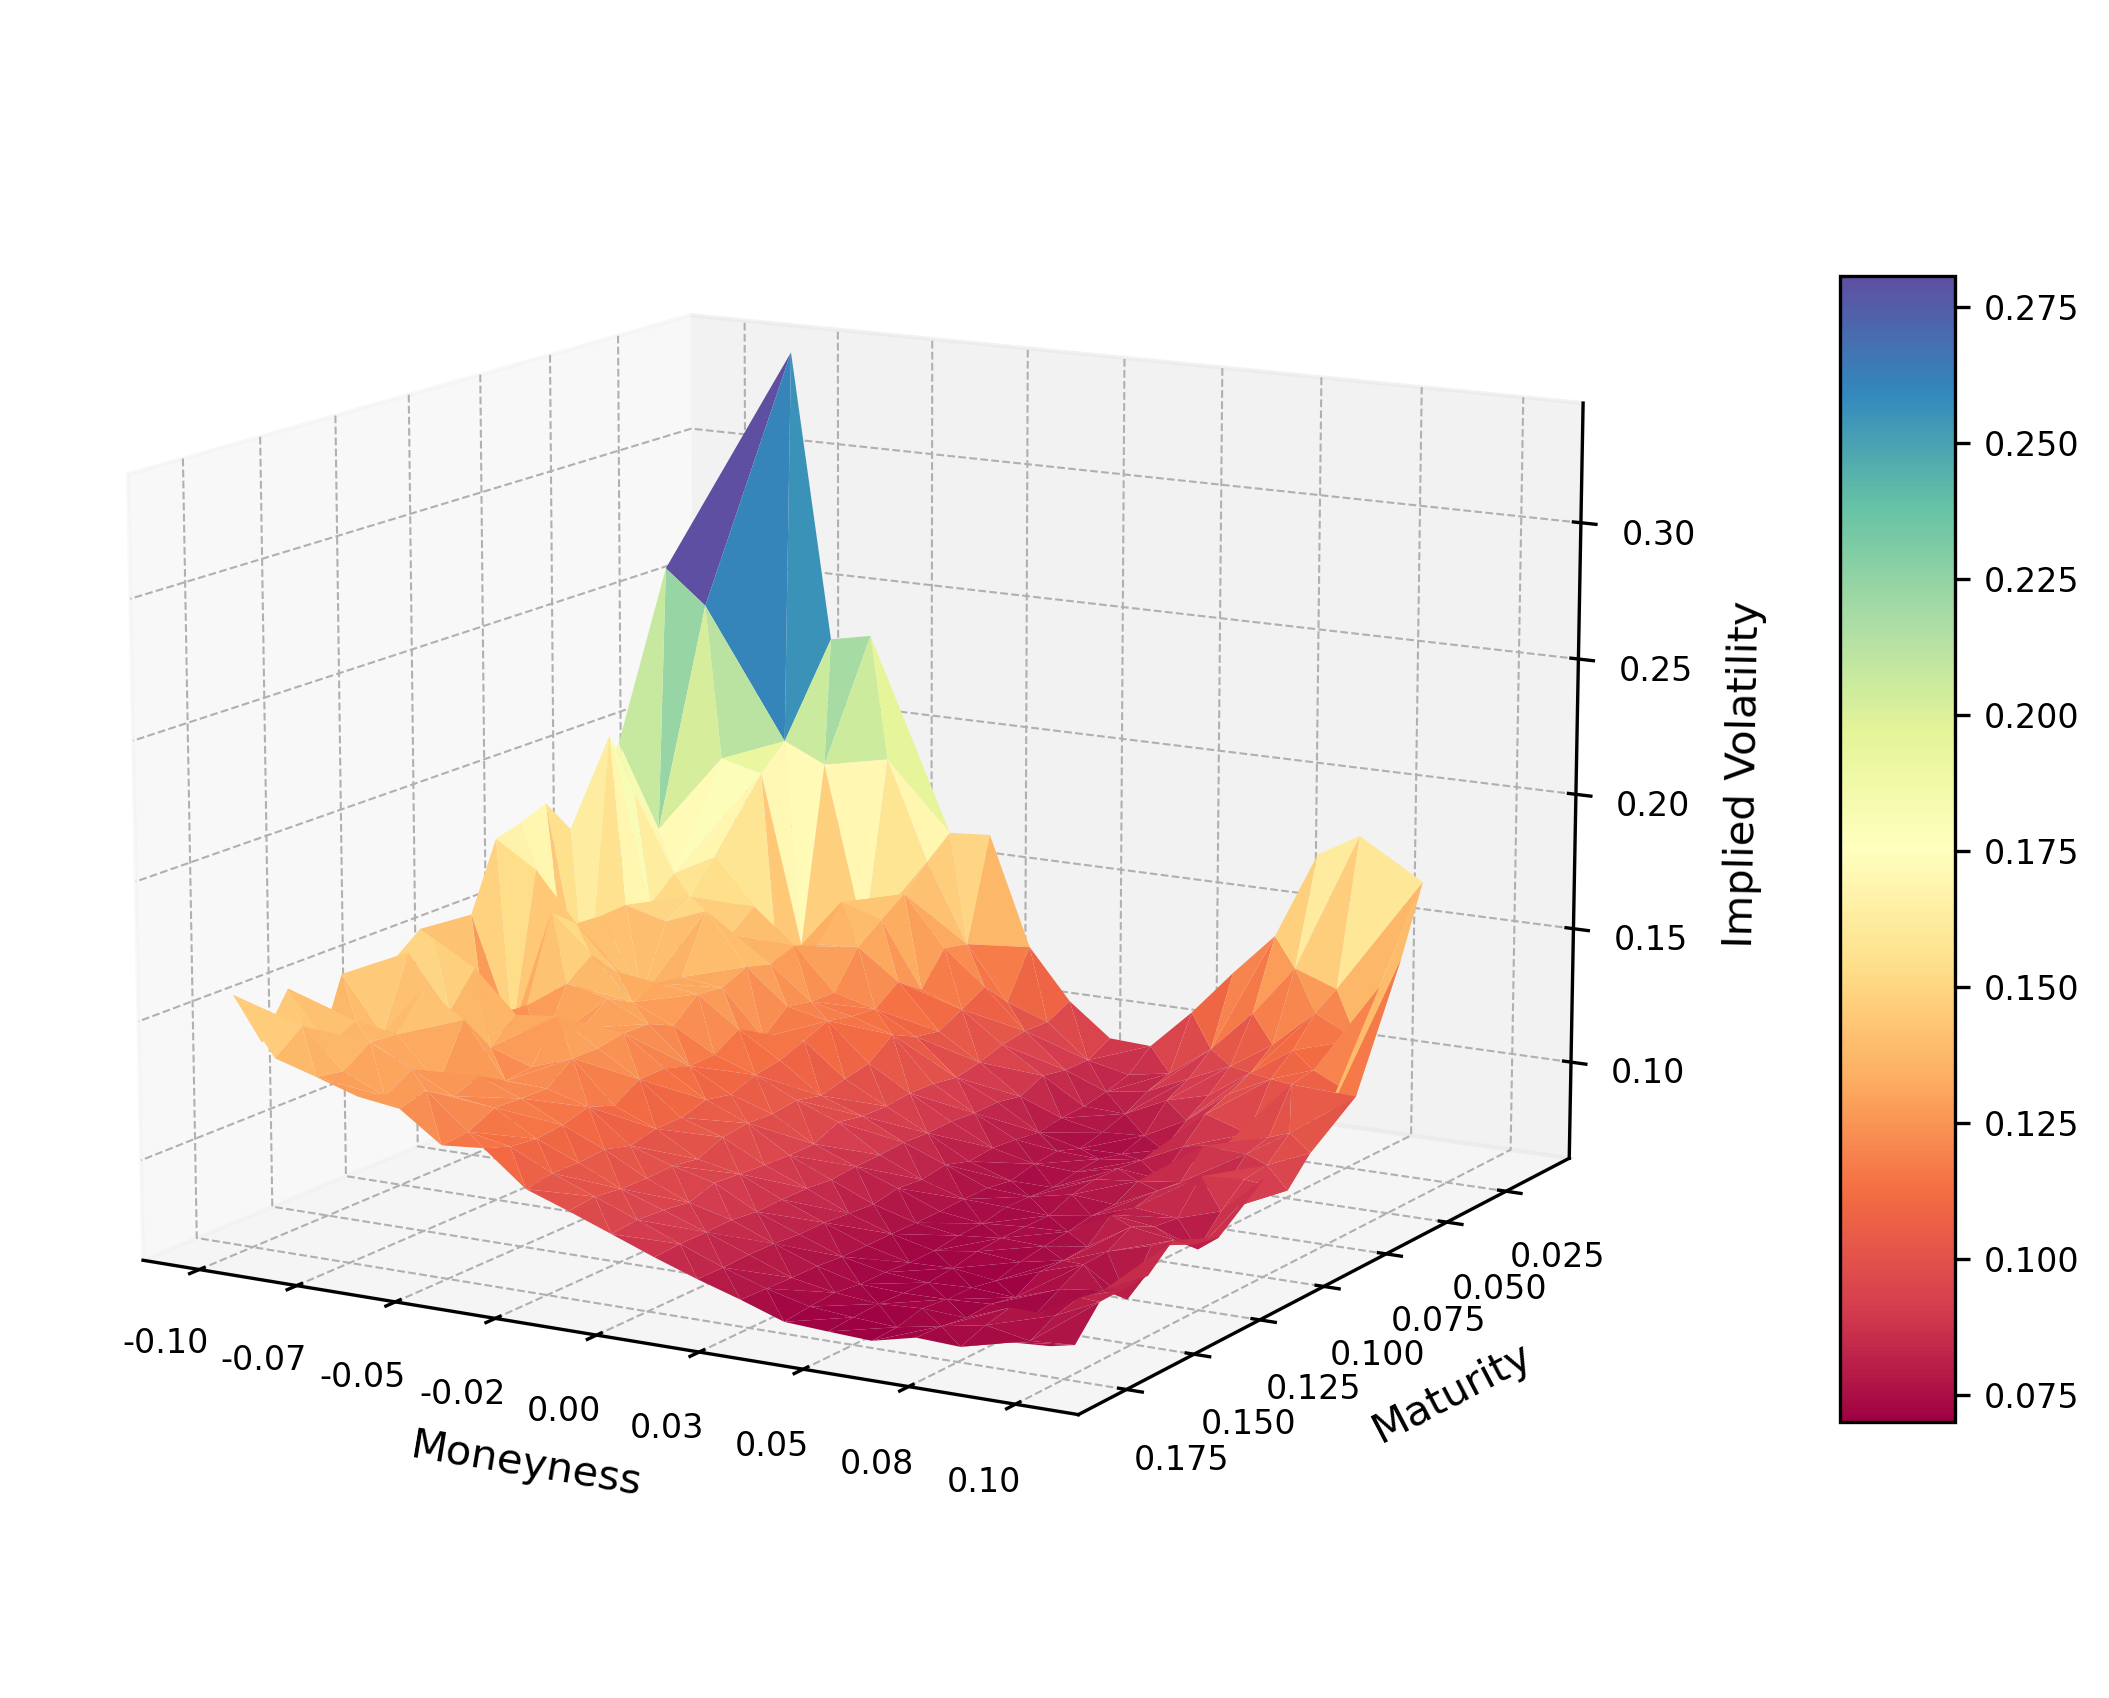

In [87]:
plot_iv_surface(plot_df.drop(columns=["implied_vol"]).dropna(), z="iv_true")

In [88]:
plot_df["re"] = np.abs(plot_df["iv"] - plot_df["iv_true"]) / plot_df["iv_true"]

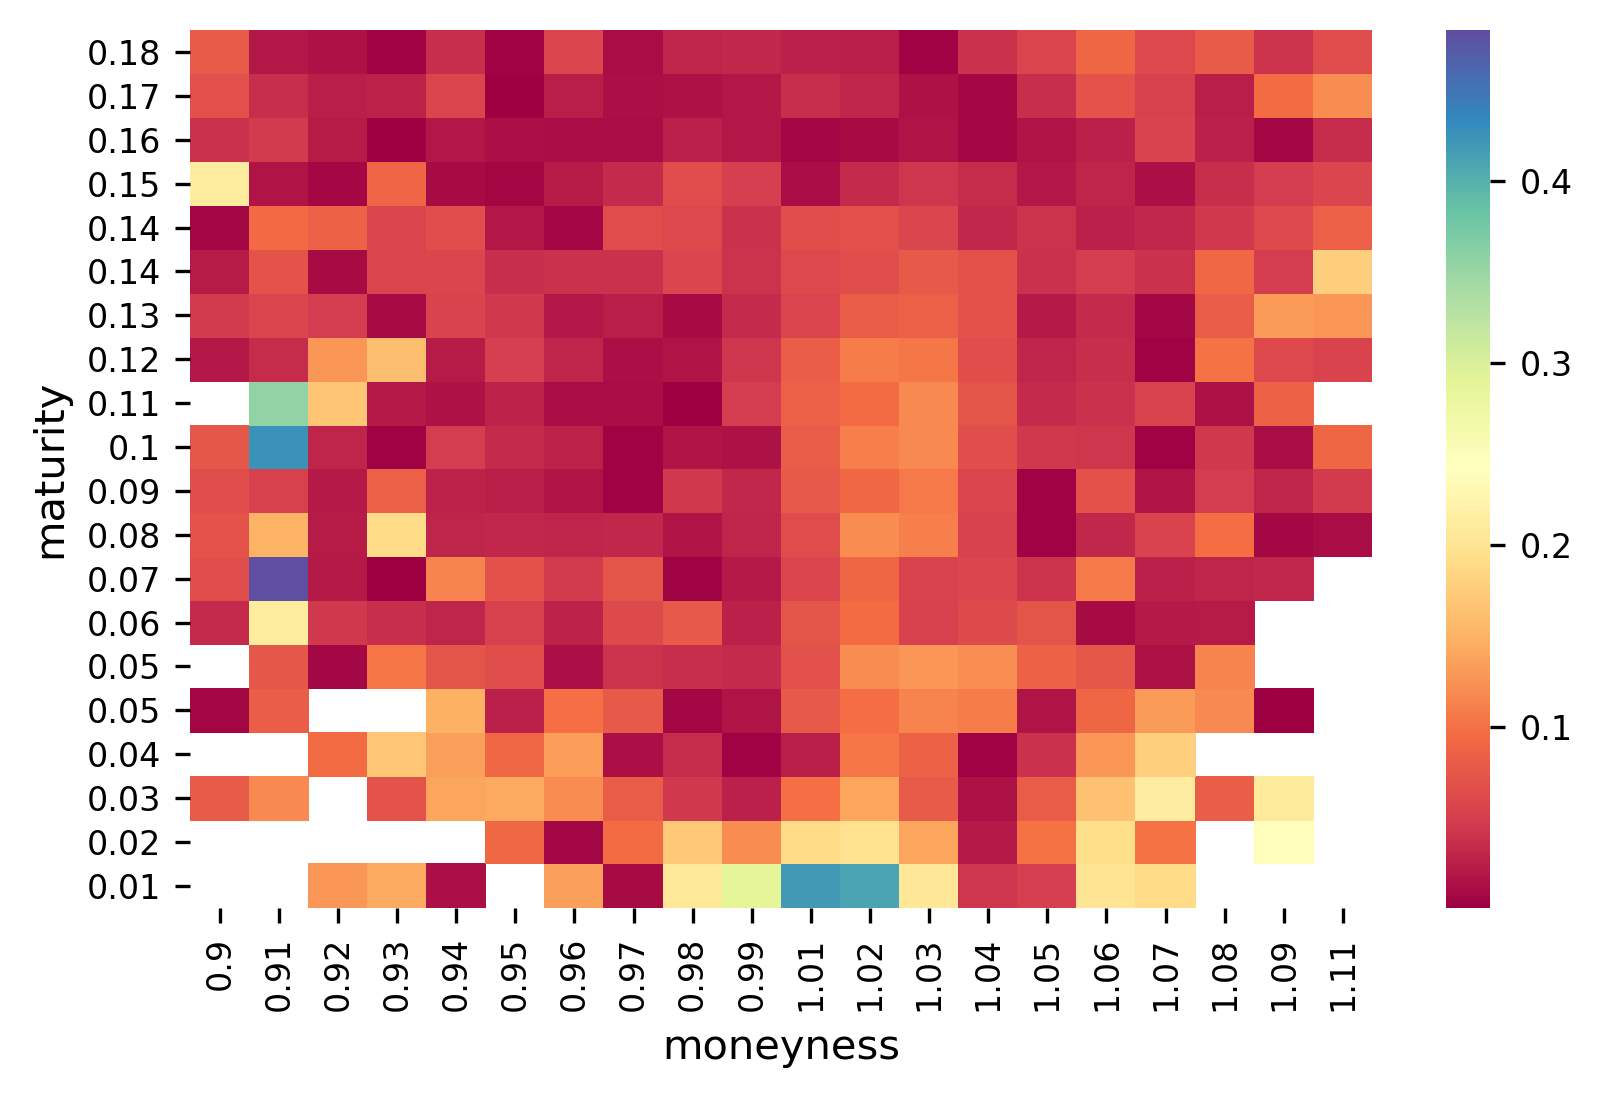

In [94]:
import seaborn as sns


data_sort = plot_df.sort_values("re", ascending=True)
data_pivot = data_sort.pivot(index="maturity", columns="moneyness", values="re")
fig = plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    data_pivot,
    cmap=plt.cm.Spectral,
    cbar=True,
    xticklabels=data_pivot.columns.values.round(2),
    yticklabels=data_pivot.index.values.round(2),
)
ax.invert_yaxis()
plt.tight_layout()

In [95]:
fig.savefig("../output/relative_error_heatmap.pdf")